这个notebook会用 “digital recognizer - data preprocessing” 储存的图像当作examples

In [24]:
# import section
import cv2
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_dir = 'data/train_data'

In [193]:
# 读取1000张label为 4 和 1 的images
two_path = os.path.join(data_dir, str(2))
twos = []
one_path = os.path.join(data_dir, str(1))
ones = []
for img in os.listdir(two_path)[:1000]:
    img_path = os.path.join(two_path, img)
    twos.append(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE))
for img in os.listdir(one_path)[:1000]:
    img_path = os.path.join(one_path, img)
    ones.append(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE))
display(len(ones), len(twos))

1000

1000

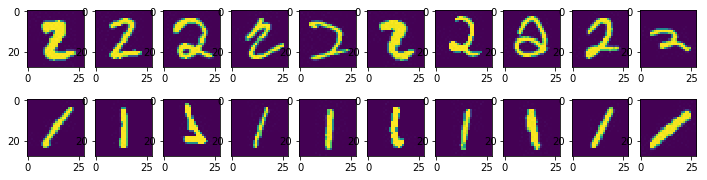

In [195]:
# plot the first 10 images for each label
pictire, ax = plt.subplots(2, 10, figsize = (12, 3))
for i in range(10):
    ax[0, i].imshow(twos[i])
    ax[1, i].imshow(ones[i])

In [150]:
# 可以发现图片显示出来很奇怪，这是因为plt.imshow的默认cmap设置原因，我们添加cmap=‘Greys’就正常了

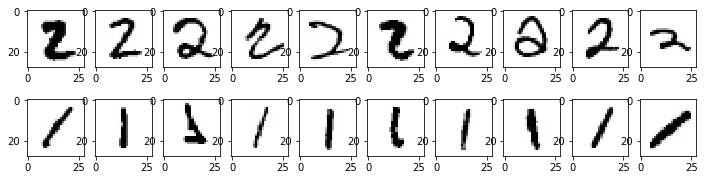

In [196]:
pictire, ax = plt.subplots(2, 10, figsize = (12, 3))
for i in range(10):
    ax[0, i].imshow(twos[i], cmap="Greys")
    ax[1, i].imshow(ones[i], cmap="Greys")

### Edge Detection

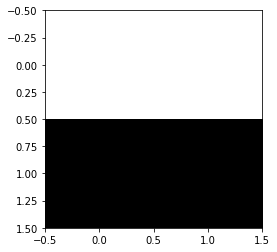

In [197]:
simple_horizental = np.array([[0, 0], [255, 255]]) # 这是一个非常简单的图片，只包含了四个pixel
plt.imshow(simple_horizental, cmap="Greys") #看下他长啥样
# 我们可以把这个图片看作一个简单的横线

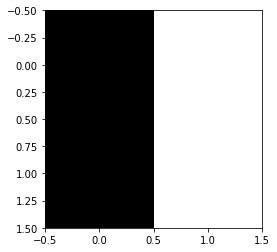

In [198]:
simple_vertical = np.array([[255, 0], [255, 0]]) # 这也是一个非常简单的图片，只包含了四个pixel
plt.imshow(simple_vertical, cmap="Greys") #看下他长啥样
# 我们可以把这个图片看作一个简单的竖线

In [208]:
# 接着我们用一个简单版本的feature kernel,这个matrix也是2*2，它可以帮我们检测到一个图片里是否包含了横线，可以自己手动乘一下感受一下
# 这里不是在做矩阵相乘！
feature_matrix = np.array([[1.5, 1.5], [-1.5, -1.5]])
def mul(matA, matB):
    sums = 0
    for i in range(2):
        for j in range(2):
            sums += matA[i][j] * matB[i][j]
    return sums
result_horizental = mul(feature_matrix, simple_horizental)
result_vertical = mul(feature_matrix, simple_vertical)
display(result_horizental, result_vertical)

-765.0

0.0

如果我们将我们的这个简单的kernel取transpose，新的matrix就是一个简单的可以探测竖线的kernel。我们可以用这两个简单kernel来extract 4和1图像中的横线，竖线features。


https://buzzrobot.com/whats-happening-inside-the-convolutional-neural-network-the-answer-is-convolution-2c22075dc68d

这个link很好的解释了kernel是怎么在更大的图像中运算的

In [212]:
hori_kernel = feature_matrix # 上面用的，探测横线
ver_kernel = np.transpose(feature_matrix) # 上面的transpose，探测竖线
def apply_kernel(kernel, img):
    return cv2.filter2D(img, -1, kernel) #就不自己手写函数乘了，用cv自带的函数
twos_hor = [apply_kernel(hori_kernel, x) for x in twos[:10]]
ones_hor = [apply_kernel(hori_kernel, x) for x in ones[:10]]
twos_ver = [apply_kernel(ver_kernel, x) for x in twos[:10]]
ones_ver = [apply_kernel(ver_kernel, x) for x in ones[:10]]

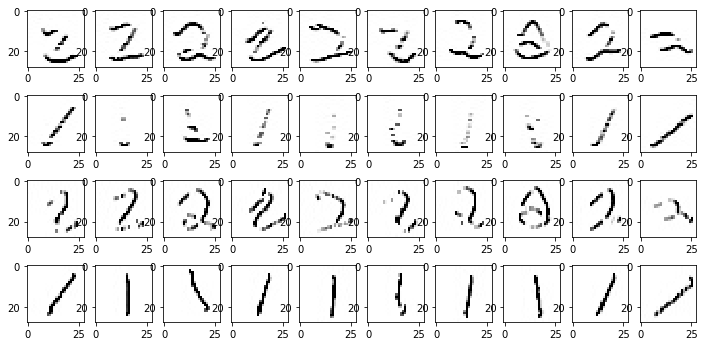

In [215]:
pictire, ax = plt.subplots(4, 10, figsize = (12, 6))
for i in range(10):
    ax[0, i].imshow(twos_hor[i], cmap="Greys") # 第一行是2的横线
    ax[1, i].imshow(ones_hor[i], cmap="Greys") # 第二行是1的横线
    ax[2, i].imshow(twos_ver[i], cmap="Greys") # 第三行是2的竖线
    ax[3, i].imshow(ones_ver[i], cmap='Greys') # 第四行是1的竖线

可以看到两个很简单的kernel还是多多少少检测到了4中的横线和1中的竖线，这一步就相当于在CNN中的feature extraction部分，在一个复杂的图像识别CNN中，我们通常会用到很多个复杂的kernel来extract 更加复杂的feature。不过如果我们只是要判断一个图片是1还是4，这两个简单的kernel已经够用了

In [299]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Dense
from keras.losses import categorical_crossentropy
model = Sequential() # create a Sequential model
model.add(Flatten()) # flatten的作用是把我们的2d 矩阵给转换成1d的
model.add(Dense(256, activation = 'relu')) # 这个与softmax 合起来是我们的prediction layer
model.add(Dense(2, activation = 'softmax'))

softmax： https://medium.com/data-science-bootcamp/understand-the-softmax-function-in-minutes-f3a59641e86d


relu and general CNN model: https://www.kaggle.com/learn/deep-learning

In [300]:
model.compile(loss=categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [297]:
# 选取头1000张1 和 头1000张2 来训练
x = ones + twos
X = []
for img in x:
    after_ver = apply_kernel(ver_kernel, img)
    after_shape = np.reshape(after_ver, (28, 28, 1)) #增加1d好用来train model
    X.append(after_shape/255) #除以255更方便train
# 各自的label
X = np.array(X)
Y = np.array(([[1, 0] for x in range(1000)] + [[0, 1] for x in range(1000)])) # 1, 0代表了是1， 0, 1代表了是2
display(len(X), len(Y))

2000

2000

In [302]:
model.fit(X, Y,
          batch_size=28,
          epochs=6,
          validation_split = 0.2)

Train on 1600 samples, validate on 400 samples
Epoch 1/6
1600/1600 [==============================] - 0s 102us/step - loss: 0.0147 - accuracy: 0.9975 - val_loss: 0.1134 - val_accuracy: 0.9675
Epoch 2/6
1600/1600 [==============================] - 0s 105us/step - loss: 0.0073 - accuracy: 0.9994 - val_loss: 0.0685 - val_accuracy: 0.9775
Epoch 3/6
1600/1600 [==============================] - 0s 94us/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0492 - val_accuracy: 0.9800
Epoch 4/6
1600/1600 [==============================] - 0s 90us/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0580 - val_accuracy: 0.9800
Epoch 5/6
1600/1600 [==============================] - 0s 85us/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0439 - val_accuracy: 0.9875
Epoch 6/6
1600/1600 [==============================] - 0s 91us/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0558 - val_accuracy: 0.9800


没有用到任何库自带的feature extraction layer(Conv2D), 仅仅只是使用了一个[[1, -1], [1, -1]] 自己定义的kernel，我们的model一样在这1000张1和2中达到了不错的accuracy

实际上我们一般会用稍微复杂一点的，能够提取更多信息的matrices。下面就是一个例子，叫做sobel operator，它可以detect到图片中的横竖edges, 下面这个link解释了为啥它可以work
https://medium.com/datadriveninvestor/understanding-edge-detection-sobel-operator-2aada303b900

<img src='sobel matrices.PNG'>

<Figure size 1152x576 with 0 Axes>

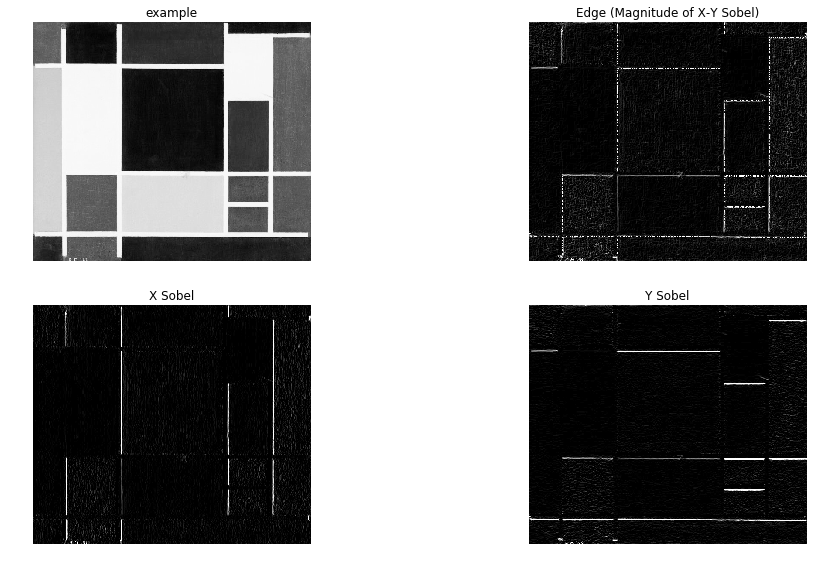

In [135]:
# using sobel on one example image
example_img= cv2.imread('data/example2.jpg')# use the first image in ones as example
plt.figure(figsize=(16, 8))
example_img = cv2.cvtColor(example_img, cv2.COLOR_BGR2GRAY)
sobelx = cv2.Sobel(example_img,-1,1,0) #单独的x
sobely = cv2.Sobel(example_img,-1,0,1)
edges = sobelx + sobely

fig, ax = plt.subplots(2, 2, figsize=(16, 8))

ax[0,0].imshow(example_img, cmap='Greys')
ax[0,0].set_title("example")
ax[0,0].axis('off')
ax[0,1].imshow(edges, cmap='gray')
ax[0,1].set_title("Edge (Magnitude of X-Y Sobel)")
ax[0,1].axis('off')
ax[1,0].imshow(sobelx, cmap='gray')
ax[1,0].set_title("X Sobel")
ax[1,0].axis('off')
ax[1,1].imshow(sobely, cmap='gray')
ax[1,1].set_title("Y Sobel")
ax[1,1].axis('off')
fig.tight_layout()

#### 不过通常我们放入我们CNN model的layers我们也是不太清楚每一个具体能够出来什么样的features的，可以参考digit recognizer的高赞notebook：https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6/notebook#3.-CNN 他在他的model里加入了两个Conv2D(size = (5, 5) 代表了是一个5乘5的matrix）和两个 Conv2D（size=（3，3））。这四个kernel扮演的角色与我们之前所用的那个简单的2*2matrices是相似的